In [10]:
!pip install xgboost shap imbalanced-learn

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc  
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

In [28]:

df = pd.read_csv('diabetes.csv') 

cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

df.fillna(df.median(), inplace=True)

X = df.drop('Outcome', axis=1)
y = df['Outcome']

print("Dataset Preview:")
df.head()

Dataset Preview:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [29]:

mi_selector = SelectKBest(score_func=mutual_info_classif, k=6)
X_mi = mi_selector.fit_transform(X, y)

selected_features = X.columns[mi_selector.get_support()].tolist()
print("Selected Features by Mutual Information:", selected_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mi)

Selected Features by Mutual Information: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [30]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Class Distribution Before SMOTE:", y.value_counts().to_dict())
print("Class Distribution After SMOTE:", pd.Series(y_resampled).value_counts().to_dict())

Class Distribution Before SMOTE: {0: 500, 1: 268}
Class Distribution After SMOTE: {1: 500, 0: 500}


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Testing Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (800, 6) (800,)
Testing Set Shape: (200, 6) (200,)


In [32]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_model = RandomForestClassifier(random_state=42)

ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model)],
    voting='soft',  
    weights=[0.6, 0.4]  
)

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
print("Hybrid Ensemble Performance:")
print(classification_report(y_test, y_pred_ensemble))
print("ROC-AUC Score:", roc_auc_score(y_test, ensemble_model.predict_proba(X_test)[:, 1]))

C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Hybrid Ensemble Performance:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79        99
           1       0.79      0.80      0.79       101

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

ROC-AUC Score: 0.8697869786978698


In [33]:
cv_scores = cross_val_score(ensemble_model, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print("5-Fold CV F1-Macro Scores:", cv_scores)
print("Mean CV F1-Macro:", cv_scores.mean())

C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

5-Fold CV F1-Macro Scores: [0.77485929 0.69407458 0.82       0.88395267 0.85338355]
Mean CV F1-Macro: 0.8052540178395123


C:\Users\Siddharth Sekhar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


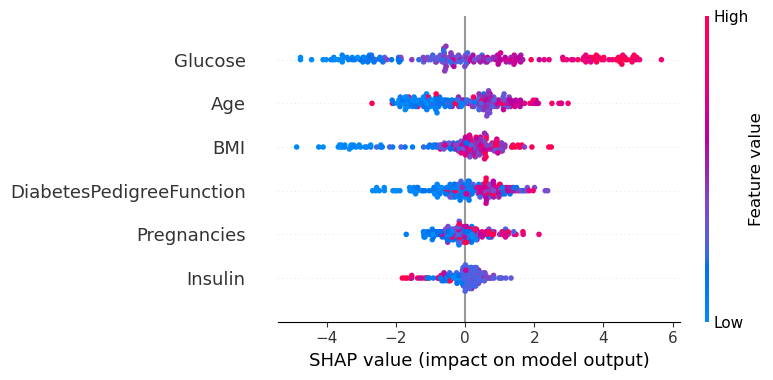

In [34]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)  # Fit before SHAP

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=selected_features, show=True)


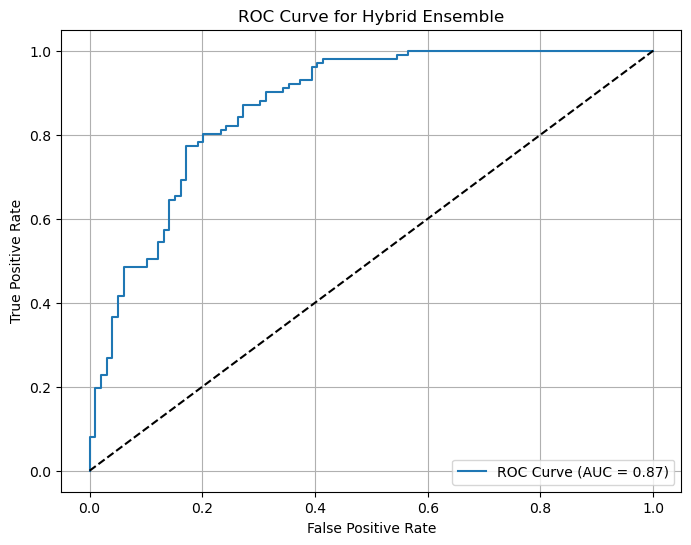

In [35]:
fpr, tpr, _ = roc_curve(y_test, ensemble_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid Ensemble')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [36]:
requirements = """
pandas
numpy
scikit-learn
xgboost
shap
imbalanced-learn
matplotlib
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("Saved dependencies to requirements.txt")

Saved dependencies to requirements.txt


In [37]:
import matplotlib.pyplot as plt
import numpy as np

mi_scores = mi_selector.scores_[mi_selector.get_support()]
plt.figure(figsize=(8, 6))
plt.bar(selected_features, mi_scores)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Selected Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mi_scores.png', bbox_inches='tight', dpi=300)
plt.close()
print("Mutual Information scores saved as mi_scores.png")

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.hist(y, bins=2, edgecolor='k', alpha=0.5, label=['Non-Diabetic', 'Diabetic'])
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=2, edgecolor='k', alpha=0.5, label=['Non-Diabetic', 'Diabetic'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight', dpi=300)
plt.close()
print("Class distribution saved as class_distribution.png")

Mutual Information scores saved as mi_scores.png
Class distribution saved as class_distribution.png
